In [ ]:
#импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams.update({'font.size': 10})
plt.style.use('seaborn-v0_8-deep')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#считываем датасет с диска
df = pd.read_csv('https://drive.google.com/uc?id=1LBDnhITL0Wqwp5G6M6IBI-SSz8BIoNec')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


###Предобработка и изучение данных

In [ ]:
#проверим датасет на наличие пропущенных значений
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [ ]:
#проверяем, какого типа у нас ячейки - категориальные или числовые
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [ ]:
#так как все столбцы числовые, то посмотрим описательную статистику датасета
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
#Выделим признаки и целевую переменную
X = df.drop('Outcome', axis = 1)
y = df['Outcome']

In [ ]:
# Нормализация данных
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование данных в тензоры
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

###Построение нейронной сети

In [ ]:
#Так как решаем задачу классификации, то последней функцией активации будет сигмоида, возвращающая вероятность принаджлежности к классу
class NeuralNet3Layers(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet3Layers, self).__init__()
        self.layer1 = nn.Linear(input_size, 16)
        self.layer2 = nn.Linear(16, 8)
        self.layer3 = nn.Linear(8, 4)
        self.output = nn.Linear(4, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

input_size = X_train.shape[1]
model3 = NeuralNet3Layers(input_size)


In [ ]:
class NeuralNet4Layers(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet4Layers, self).__init__()
        self.layer1 = nn.Linear(input_size, 32)
        self.layer2 = nn.Linear(32, 16)
        self.layer3 = nn.Linear(16, 8)
        self.layer4 = nn.Linear(8, 4)
        self.output = nn.Linear(4, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        x = self.sigmoid(self.output(x))
        return x

model4 = NeuralNet4Layers(input_size)


###Обучение

In [ ]:
def train_model(model, X_train, y_train, num_epochs=100, learning_rate=0.01):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_values = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad() # обнуление градиентов
        outputs = model(X_train) # прямое распространение
        loss = criterion(outputs, y_train) # вычисление функции потерь
        loss.backward() # обратное распространение
        optimizer.step() # смена весов
        loss_values.append(loss.item())

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    return loss_values


Epoch [10/100], Loss: 0.1585
Epoch [20/100], Loss: 0.1356
Epoch [30/100], Loss: 0.1318
Epoch [40/100], Loss: 0.1275
Epoch [50/100], Loss: 0.1249
Epoch [60/100], Loss: 0.1227
Epoch [70/100], Loss: 0.1209
Epoch [80/100], Loss: 0.1189
Epoch [90/100], Loss: 0.1169
Epoch [100/100], Loss: 0.1148


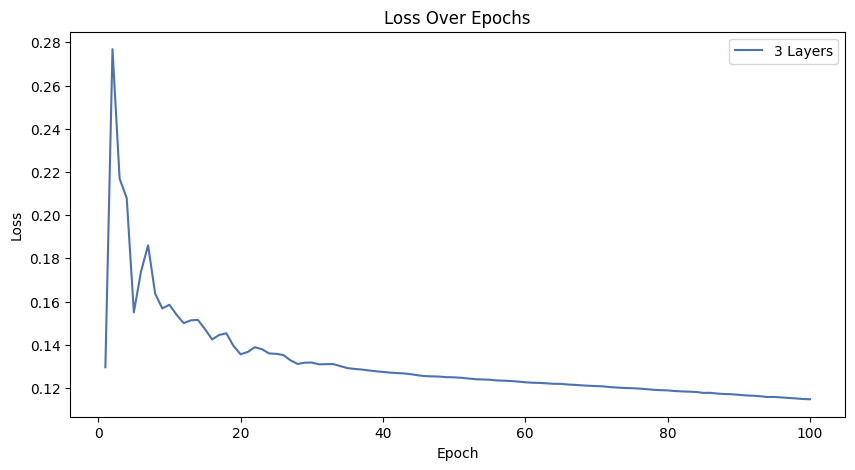

In [ ]:
loss_values3 = train_model(model3, X_train, y_train)

# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(range(1, 101), loss_values3, label='3 Layers')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()


Epoch [10/100], Loss: 0.3489
Epoch [20/100], Loss: 0.2065
Epoch [30/100], Loss: 0.1598
Epoch [40/100], Loss: 0.1481
Epoch [50/100], Loss: 0.1409
Epoch [60/100], Loss: 0.1321
Epoch [70/100], Loss: 0.1257
Epoch [80/100], Loss: 0.1187
Epoch [90/100], Loss: 0.1113
Epoch [100/100], Loss: 0.1045


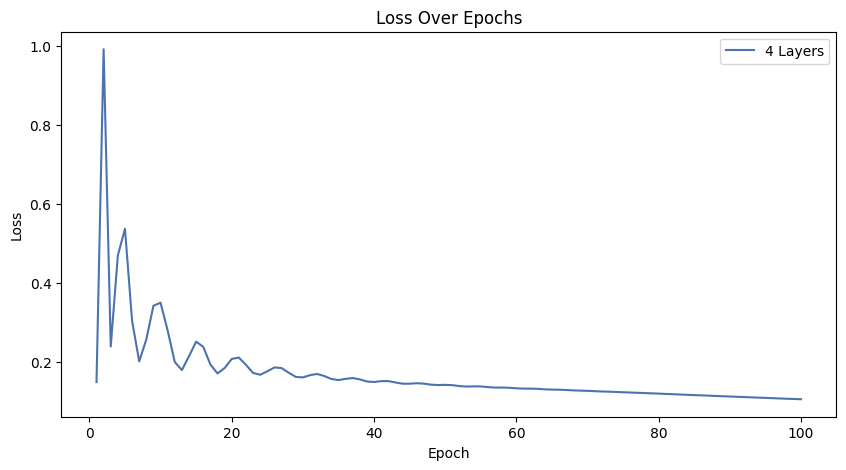

In [ ]:
loss_values4 = train_model(model4, X_train, y_train)

# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(range(1, 101), loss_values4, label='4 Layers')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()


### Оценка производительности

In [ ]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        predictions = predictions.round()
        accuracy = accuracy_score(y_test, predictions)
    return accuracy


In [ ]:
accuracy3 = evaluate_model(model3, X_test, y_test)
print(f'Точность модели с 3 слоями: {accuracy3:.4f}')

Точность модели с 3 слоями: 0.7338


In [ ]:
accuracy4 = evaluate_model(model4, X_test, y_test)
print(f'Точность модели с 4 слоями: {accuracy4:.4f}')

Точность модели с 4 слоями: 0.6948
